<a href="https://colab.research.google.com/github/surajghuwalewala/CE888_Data_Science_and_Decision_Making/blob/master/Lab_8/2_Exercise-Food-11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Download the VGG16 file from Github
! curl https://raw.githubusercontent.com/surajghuwalewala/CE888_Data_Science_and_Decision_Making/master/Lab_8/vgg16.py --output vgg16.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8740  100  8740    0     0  43700      0 --:--:-- --:--:-- --:--:-- 43700


In [2]:
!pip install tensorflow==1.3.0
!pip install keras==2.0.7

     |████████████████████████████████| 43.6MB 69kB/s 
     |████████████████████████████████| 1.6MB 32.8MB/s 
     |████████████████████████████████| 890kB 28.1MB/s 
  Created wheel for html5lib: filename=html5lib-0.9999999-cp36-none-any.whl size=107220 sha256=b54cb73447d0adaca74625c9978db95491f87a56dd4ca326026a3db23c3eff6f
  Stored in directory: /root/.cache/pip/wheels/50/ae/f9/d2b189788efcf61d1ee0e36045476735c838898eef1cad6e29
Successfully built html5lib
ERROR: stable-baselines 2.2.1 has requirement tensorflow>=1.5.0, but you'll have tensorflow 1.3.0 which is incompatible.
ERROR: magenta 0.3.19 has requirement tensorflow>=1.12.0, but you'll have tensorflow 1.3.0 which is incompatible.
  Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Found existing installation: bleach 3.1.0
    Uninstalling bleach-3.1.0:
      Successfully uninstalled bleach-3.1.0
  Found existing installation: tensorflow 1.15.0
    Uninst

In [3]:
import os
os.environ['KAGGLE_USERNAME'] = "surajghuwalewala" # username from the json file
os.environ['KAGGLE_KEY'] = "c14ff4f2803c1ffb349c4b9e1a57020b" # key from the json file
DOWNLOAD_DATA = True

if DOWNLOAD_DATA:
    !kaggle datasets download -d trolukovich/food11-image-dataset # api copied from kaggle
    !unzip -q /content/food11-image-dataset.zip   ## '-q' unzips without verbose output

100% 1.08G/1.08G [00:15<00:00, 110MB/s] 
100% 1.08G/1.08G [00:15<00:00, 76.1MB/s]


In [0]:
train_dir = '/content/training/'
test_dir = '/content/evaluation/'
val_dir = '/content/validation/'

In [6]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)

IMG_SIZE = 224

train_generator = datagen.flow_from_directory(train_dir,
                                                    target_size=(IMG_SIZE, IMG_SIZE), 
                                                    batch_size=100,
                                                    class_mode='categorical')

validation_generator = datagen.flow_from_directory(val_dir,
                                                        target_size=(IMG_SIZE, IMG_SIZE),
                                                        batch_size=100,
                                                        class_mode='categorical')

test_generator = datagen.flow_from_directory(test_dir,
                                                    target_size=(IMG_SIZE, IMG_SIZE),
                                                    batch_size=100,
                                                    class_mode='categorical')


Found 9866 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.
Found 3347 images belonging to 11 classes.


In [7]:
from keras.layers import merge, Input
from vgg16 import VGG16
from keras.layers import Dense, Activation, Flatten
from keras.models import Model


image_input = Input(shape=(224, 224, 3)) # shape of a single image

model = VGG16(input_tensor=image_input, include_top=True,weights='imagenet') # load VGG-16 model with 'top = true'
model.summary()

548552704/553467096 [============================>.] - ETA: 0s_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (M

In [8]:
last_layer = model.get_layer('block5_pool').output
x= Flatten(name='flatten')(last_layer)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(64, activation='relu', name='fc2')(x)
out = Dense(11, activation='softmax', name='output')(x)  ## 11 classes
custom_vgg_model2 = Model(image_input, out)
custom_vgg_model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [9]:
# freeze all the layers except the dense layers
for layer in custom_vgg_model2.layers[:-3]:
	layer.trainable = False

custom_vgg_model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
custom_vgg_model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [11]:
history = custom_vgg_model2.fit_generator(train_generator,
                              steps_per_epoch=10,
                              epochs=2,
                              validation_data=validation_generator,
                              validation_steps=2)

Epoch 1/2
10/10 [==============================] - 1003s - loss: 3.1641 - acc: 0.1380 - val_loss: 2.1706 - val_acc: 0.2450
Epoch 2/2
10/10 [==============================] - 996s - loss: 2.0869 - acc: 0.2810 - val_loss: 1.9743 - val_acc: 0.3050


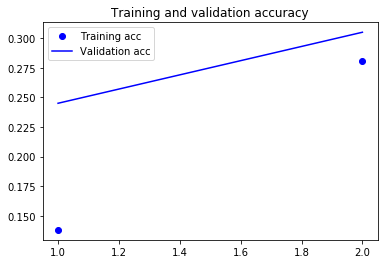

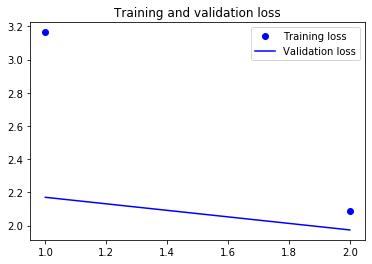

In [12]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [16]:
loss, accuracy = custom_vgg_model2.evaluate_generator(test_generator, steps=3)

print("Accuracy: ", accuracy)
print("Loss: ", loss)

Accuracy:  0.3700000047683716
Loss:  1.8685798645019531
